## 【量化分析】KD指標回測實戰
本文來源[Tej medium](https://medium.com/tej-api-%E9%87%91%E8%9E%8D%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90/%E9%87%8F%E5%8C%96%E5%88%86%E6%9E%90-%E5%8D%81-kd%E6%8C%87%E6%A8%99%E5%9B%9E%E6%B8%AC%E5%AF%A6%E6%88%B0-5e743c10468b)

### 一、前言

KD指標是技術分析常見的指標之一，主要用於判斷股價當前的強弱程度與可能反轉的時機。KD指標的數值介於0-100，一般以50作為分水嶺，當指標大於50時，表示股價處於強勢階段；反之，當股價小於50時，股價屬於弱勢階段。另外，當KD指標小於20時，股票往往有超賣的跡象，隨時有反轉向上的可能；反之當KD指標大於80時，股票往往有超買的跡象，隨時有反轉向下的可能。因此，許多人依此來建構交易訊號，作為買賣股票的依據。

KD指標的計算流程:

- RSV = ((當日收盤價-近N日的最低價)/(近N日的最高價-近N日的最低價))*100
- K值 = 昨日K值 × (2/3) + 當日RSV × (1/3)
- D值 = 昨日D值 × (2/3) + 當日K值 × (1/3)

從算式來看，可以把RSV解讀成當日股價相較於近N日 (本文N = 9)股價，是屬於較強勢還是弱勢。K值，又被稱為快線，因為受到當日股價強弱的影響較大；而D值計算的原理如同再進行一次平滑，故對當前股價變化反應較慢。

本文採用KD指標來判斷股價反轉時機，利用以下進出場規則建立交易策略並進行回測:
- K ≤ 20，買入，因其代表股價處於較弱、市場過冷
- K ≥ 80，賣出，代表市場過熱，因此選擇獲利了結

### 二、 環境設定 & import package
2.1 輸入tejapi key

In [1]:
import os
os.environ['TEJAPI_KEY'] = "your key" 
os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"

2.2 import package

In [2]:
import pandas as pd
import numpy as np
import pytz
import matplotlib.pyplot as plt

# import zipline
from zipline.data import bundles
from zipline.utils.calendar_utils import get_calendar

from zipline.api import *
from zipline.finance.commission import PerDollar,PerShare, PerTrade, PerContract
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage, VolatilityVolumeShare
from talib import EMA,STOCH

from zipline.sources.TEJ_Api_Data import (get_Treasury_Return,
                                          get_Benchmark_Return)

from zipline.utils.run_algo import  (get_transaction_detail,
#                                      get_data_for_alphalens,
                                     get_record_vars)

import pyfolio as pf

plt.rcParams['axes.unicode_minus'] = False

### 三、樣本&期間
3.1 設定股票池與期間

- 股票池：輸入81檔權值股與加權股價報酬指數(IR0001)
- 期間：從2012-2022年

In [3]:
# set stocklist
StockList = \
['1101', '1102', '1216', '1301', '1303', '1326', '1402', '1722', '2002', '2105', '2201', '2207', '2301',
 '2303', '2308', '2311', '2317', '2324', '2325', '2330', '2347', '2353', '2354', '2357', '2382', '2409',
 '2412', '2454', '2474', '2498', '2801', '2880', '2881', '2882', '2883', '2885', '2886', '2890', '2891',
 '2892', '2912', '3008', '3045', '3231', '3481', '3673', '3697', '4904', '5880', '6505', '2884', '4938',
 '2887', '2227', '9904', '3474', '2395', '2408', '1476', '2823', '2633', '5871', '2327', '3711', '2492',
 '5876', '9910', '2888', '6669', '2379', '6415', '3034', '1590', '8046', '2603', '2609', '2615', '8454',
 '3037', '6770', '1605', 'IR0001']

# set backtest period
start='2012-01-01'
end='2022-12-30'

start_dt, end_dt = pd.Timestamp(start, tz = pytz.utc), pd.Timestamp(end, tz = pytz.utc)

3.2 樣本與期間設定輸入，並利用tejapi將開高低收量、調整股價資料綁入zipline
- 綁入名稱為tquant的資料庫，並指定交易日為台股交易日誌:TEJ_XTAI

In [4]:
os.environ['ticker'] = ' '.join(StockList)
os.environ['mdate'] = start+' '+end

In [5]:
!zipline ingest -b tquant

In [6]:
# calendar
calendar_name='TEJ_XTAI'  
# bundle_name
bundle_name = 'tquant'

### 四、建構交易策略

本範例運用KD指標來建構交易策略，在指標顯示超賣時買進，在指標顯示超買時賣出，並以2330台積電為樣本。

**交易策略的進出場規則：**

- Long Entry:
    - K ≤ 20，買入股票池中條件成立股票，配置帳戶資金1%。

- Short Entry:
    - K ≥ 80，賣出條件成立股票。

**交易成本設定：**
- 設定單次買賣股票金額的0.29%為佣金費用
- 設定0%為滑價成本

4.1 交易策略參數設定

In [7]:
# These lines are for the dynamic text reporting
from IPython.display import display
import ipywidgets as widgets
out = widgets.HTML()
display(out)

"""
Model Settings
"""
starting_portfolio = 1e6
rsv_param=9
k_param=3
d_param=3

'''
cost params setting
'''
commission_pct = 0.0029
slippage_volume_limit = 1.0
slippage_impact = 0

HTML(value='')

4.2 交易策略初始化設定

In [8]:
def initialize(context):
    
    set_commission(PerDollar(cost=commission_pct))
    set_slippage(VolumeShareSlippage(volume_limit=slippage_volume_limit, price_impact=slippage_impact)) 
        
    bundle_data = bundles.load('tquant')
    context.universe = bundle_data.asset_finder.retrieve_all(bundle_data.asset_finder.equities_sids)  
        
    # setting benchmark
    set_benchmark(symbol('IR0001'))     

def handle_data(context, data):
    
    today = data.current_session.date()  
    
    for _asset in context.universe:

        trailing_window = data.history(_asset,['high','low','close'],bar_count=40,frequency='1d')

        if trailing_window.isnull().values.any():
            continue
        
        h_high = trailing_window['high'].values
        h_low = trailing_window['low'].values
        h_close = trailing_window['close'].values
    
        short_kd,long_kd = STOCH(h_high,h_low,h_close, fastk_period=rsv_param, slowk_period=k_param, slowd_period=d_param)
        
        p = context.portfolio.positions[_asset].amount
        
        if (p==0 and short_kd[-1] <=20) :
            order_target_percent(_asset, 0.01)

        elif (p>0 and short_kd[-1] >=80) :
            order_target_percent(_asset, 0.0)

In [9]:
from zipline import run_algorithm

start_date = pd.Timestamp('2022-01-01',tz='utc')
end_date = pd.Timestamp('2022-12-26',tz='utc')

results = run_algorithm(start= start_date,  
                       end=end_date,
                       initialize=initialize,                      
                       capital_base=starting_portfolio,                      
                       handle_data=handle_data,
                       data_frequency='daily',
                       bundle='tquant'
                       )

<AxesSubplot:>

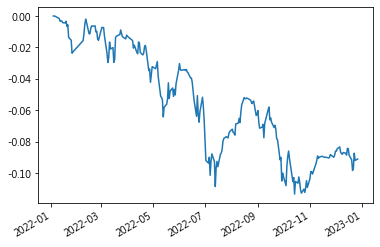

In [10]:
results.returns.cumsum().plot()

### 五、策略績效分析
5.1 利用pyfolio分析評估策略的風險與報酬表現

Start date,2022-01-03
End date,2022-12-26
Total months,11
,Backtest
Annual return,-9.364%
Cumulative returns,-9.01%
Annual volatility,8.279%
Sharpe ratio,-1.15
Calmar ratio,-0.85
Stability,0.83
Max drawdown,-10.995%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,11.00,2022-01-04,2022-10-13,NaT,NaN
1,NaN,NaT,NaT,NaT,NaN
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


Stress Events,mean,min,max
New Normal,-0.04%,-1.60%,1.38%


Top 10 long positions of all time,max
sid,
2615,1.25%
6415,1.24%
2498,1.18%
1476,1.14%
8454,1.13%
9910,1.13%
2603,1.13%
2227,1.12%
2609,1.11%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
2615,1.25%
6415,1.24%
2498,1.18%
1476,1.14%
8454,1.13%
9910,1.13%
2603,1.13%
2227,1.12%
2609,1.11%


Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.


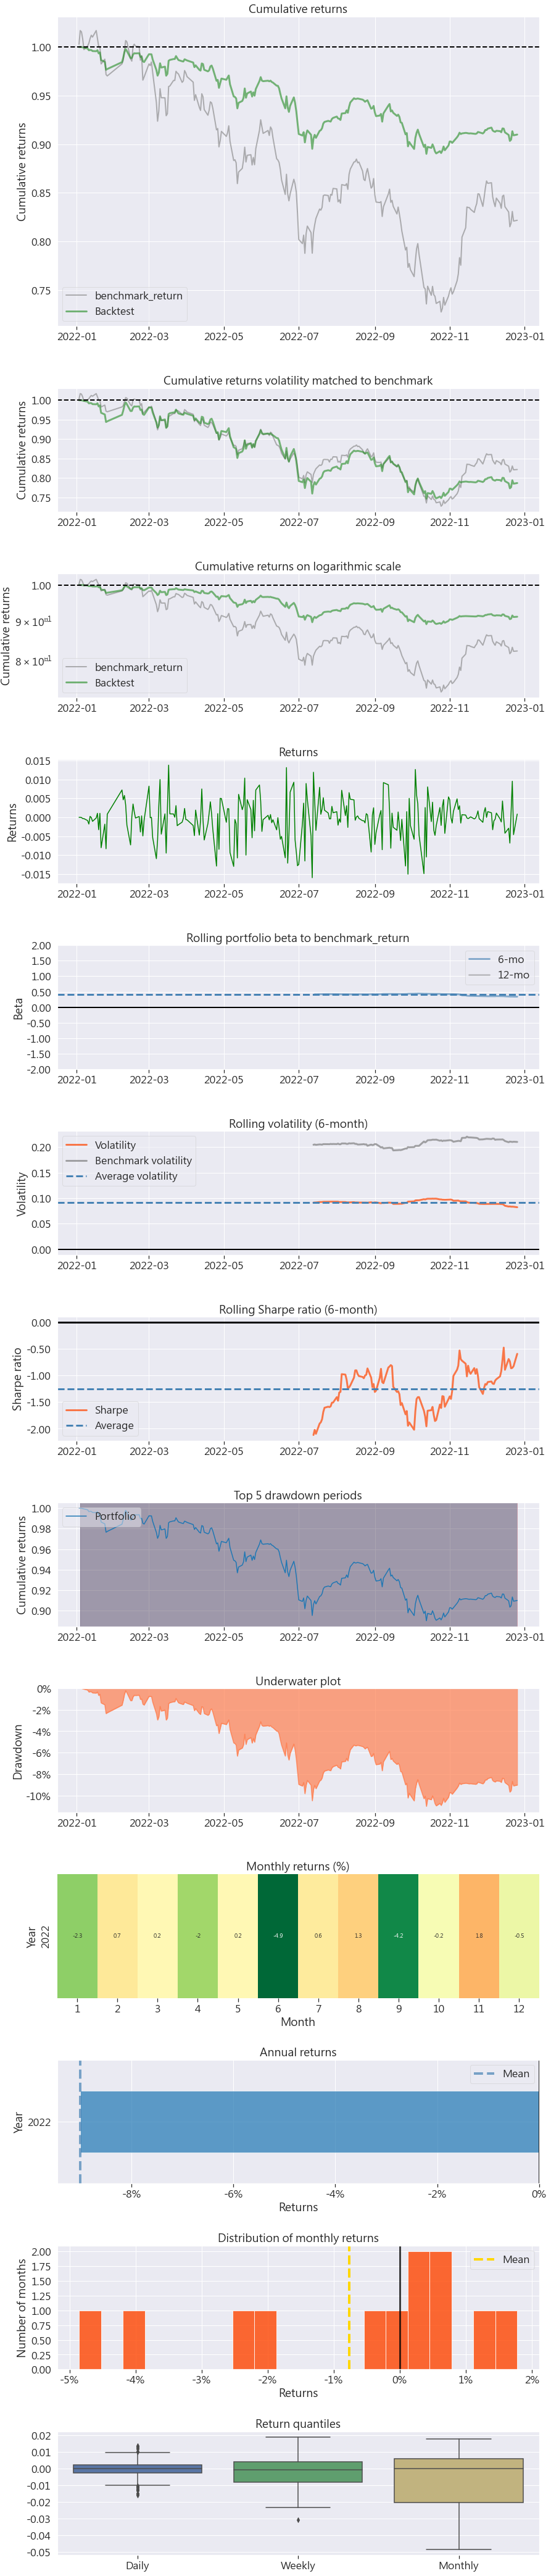

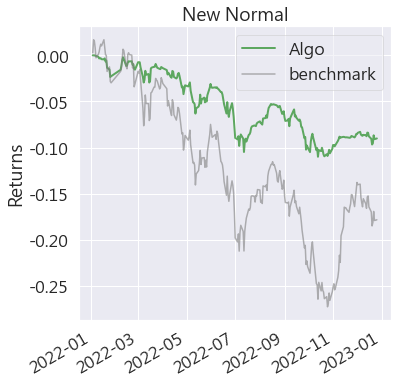

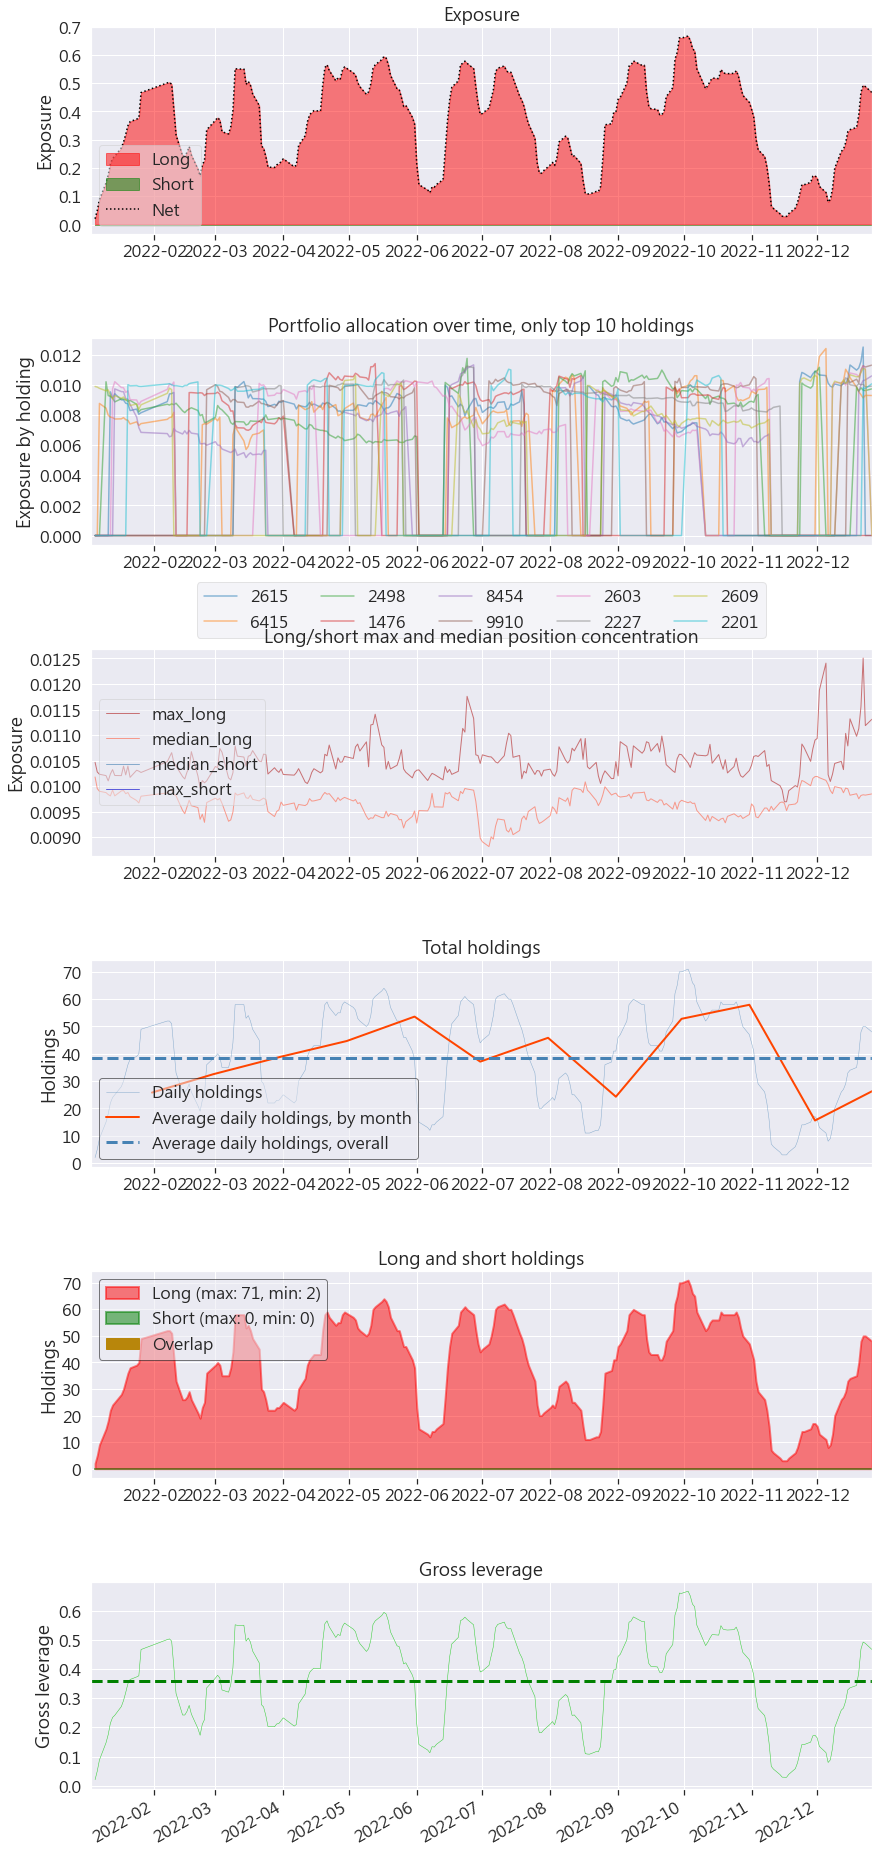

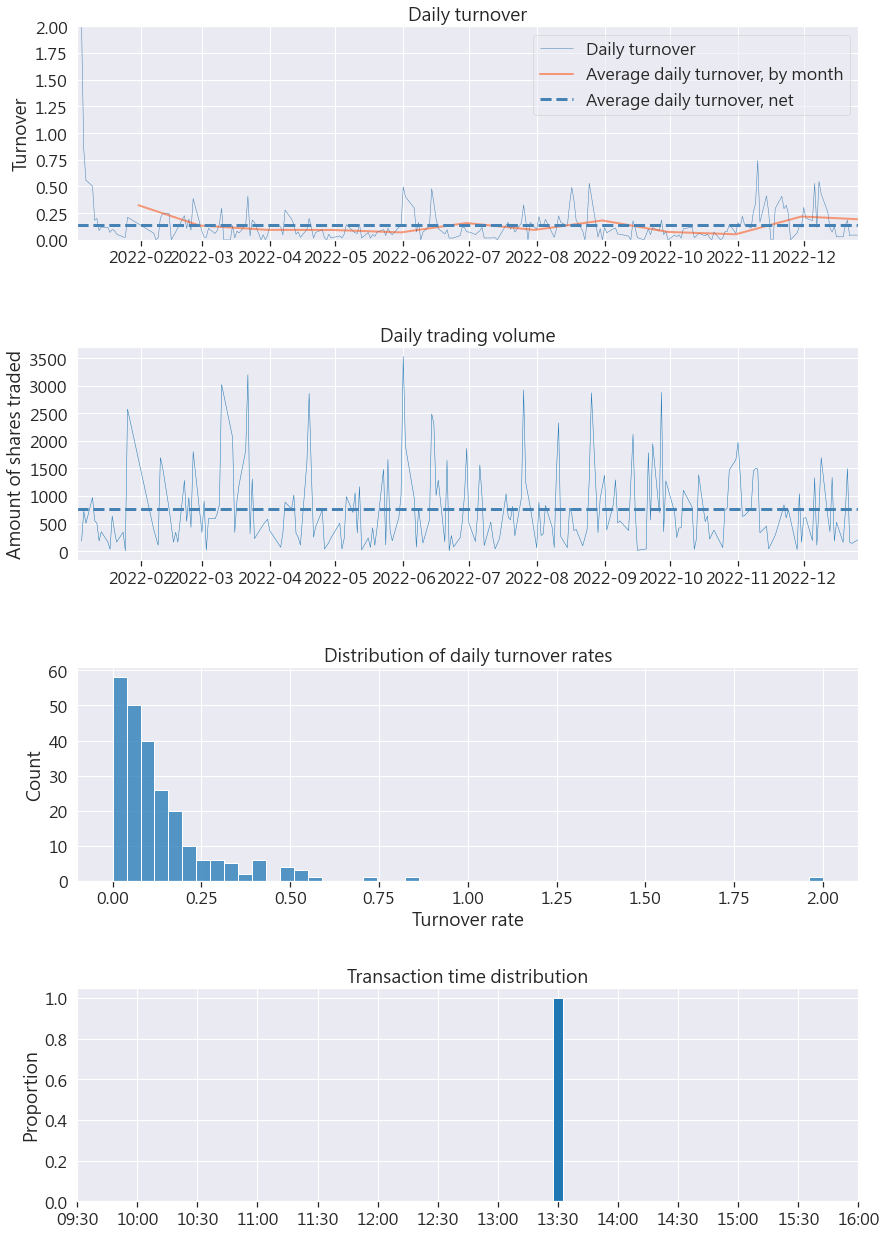

In [11]:
import pyfolio as pf
import empyrical

bt_returns, bt_positions, bt_transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return

# Creating a Full Tear Sheet
pf.create_full_tear_sheet(bt_returns, positions=bt_positions, transactions=bt_transactions,
                          benchmark_rets=benchmark_rets,
                          #live_start_date='2022-01-01', 
                          round_trips=False)